# **Intel Image Classification using TinyVGG**

## **Import Dependencies**

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from tqdm import tqdm
import cv2
import random
import torch
from torch import nn
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams['font.serif'] = "Times New Roman"

torch.__version__

'2.4.0'

## **Explore the Data Folders**

In [2]:
# Define the folder paths
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

# Get the number of images per class for each paths
for path in [train_path, test_path]:
    print(f"{path}\n---------------")
    categorical_paths = glob(pathname=path+"/*")
    for cat_path in categorical_paths:
        folder_name = cat_path.split("/")[-1]
        no_of_images = len(os.listdir(cat_path))
        print(f"Found {no_of_images} images in folder {folder_name}.") 
        
    print("\n")
    
# Print the number of images in the 'seg_pred' folder
print(f"Found {len(os.listdir(pred_path))} images in folder seg_pred.")

/kaggle/input/intel-image-classification/seg_train/seg_train
---------------
Found 2512 images in folder mountain.
Found 2382 images in folder street.
Found 2191 images in folder buildings.
Found 2274 images in folder sea.
Found 2271 images in folder forest.
Found 2404 images in folder glacier.


/kaggle/input/intel-image-classification/seg_test/seg_test
---------------
Found 525 images in folder mountain.
Found 501 images in folder street.
Found 437 images in folder buildings.
Found 510 images in folder sea.
Found 474 images in folder forest.
Found 553 images in folder glacier.


Found 7301 images in folder seg_pred.


## **Prepare the Data**

In [35]:
# Check the size of the images
# Get the number of images per class for each paths
for path in [train_path, test_path]:
    print(f"{path}\n---------------")
    categorical_paths = glob(pathname=path+"/*")
    image_sizes = []
    for cat_path in tqdm(categorical_paths):
        file_paths = glob(cat_path+"/*")
        for f_path in file_paths:
            img = plt.imread(f_path)
            shape = img.shape
            image_sizes.append(shape)
            
    print(pd.Series(image_sizes).value_counts())

/kaggle/input/intel-image-classification/seg_train/seg_train
---------------


100%|██████████| 6/6 [00:34<00:00,  5.68s/it]


(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64
/kaggle/input/intel-image-classification/seg_test/seg_test
---------------


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(72, 150, 3)        1
Name: count, dtype: int64


In [36]:
# Resize the images and store in seperate variables
X_train, X_test = [], []
y_train, y_test = [], []
X_pred = []

code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

# Set the resize parameter
SIZE = 128

# Get the number of images per class for each paths
for path in [train_path, test_path]:
    print(f"{path}\n---------------")
    categorical_paths = glob(pathname=path+"/*")
    for cat_path in tqdm(categorical_paths):
        cat_name = cat_path.split("/")[-1]
        file_paths = glob(cat_path+"/*")
        for f_path in file_paths:
            img = cv2.imread(f_path)
            img_resized = cv2.resize(img, (SIZE, SIZE))
            
            if "train" in path:
                X_train.append(img_resized)
                y_train.append(code[cat_name])
            else:
                X_test.append(img_resized)
                y_test.append(code[cat_name])
                
for f_path in tqdm(glob(pathname=pred_path+"/*")):
    img = cv2.imread(f_path)
    img_resized = cv2.resize(img, (SIZE, SIZE))
    X_pred.append(img_resized)

/kaggle/input/intel-image-classification/seg_train/seg_train
---------------


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


/kaggle/input/intel-image-classification/seg_test/seg_test
---------------


100%|██████████| 7301/7301 [00:16<00:00, 433.67it/s]


In [37]:
# Change the list to numpy array
X_train, X_test, X_pred = np.array(X_train), np.array(X_test), np.array(X_pred)
y_train, y_test = np.array(y_train), np.array(y_test)

X_train.shape, X_test.shape, X_pred.shape, y_train.shape, y_test.shape

((14034, 128, 128, 3),
 (3000, 128, 128, 3),
 (7301, 128, 128, 3),
 (14034,),
 (3000,))

In [38]:
# Convert the channel last to channel first
X_train, X_test, X_pred = np.transpose(X_train, (0, 3, 1, 2)), np.transpose(X_test, (0, 3, 1, 2)), np.transpose(X_pred, (0, 3, 1, 2))
X_train.shape, X_test.shape, X_pred.shape, y_train.shape, y_test.shape

((14034, 3, 128, 128),
 (3000, 3, 128, 128),
 (7301, 3, 128, 128),
 (14034,),
 (3000,))

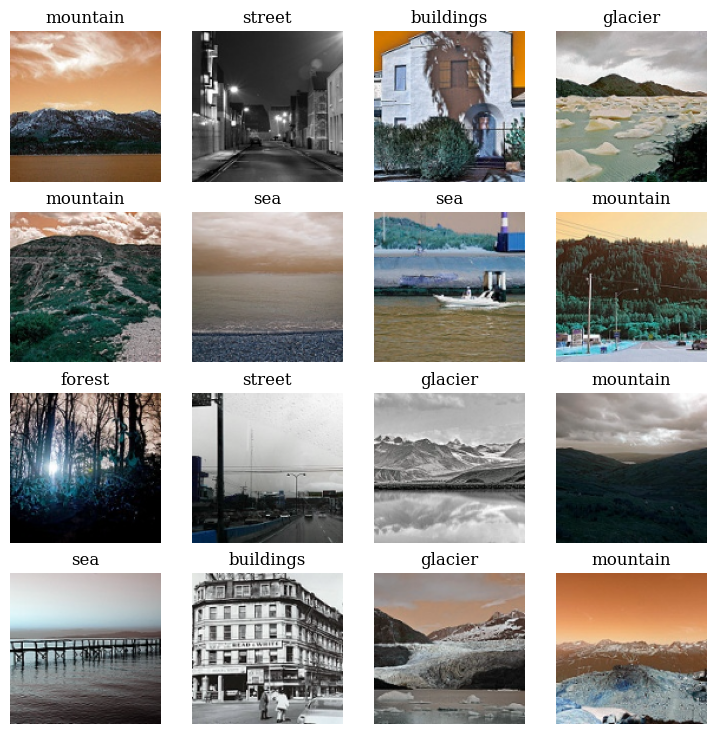

In [39]:
# Plot some random images from the training data
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_id = random.randint(0, X_train.shape[0])
    X, y = X_train[random_id], y_train[random_id]
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.transpose(X, [1, 2, 0]))
    plt.title([key for key, value in code.items() if value == y][0])
    plt.axis(False)

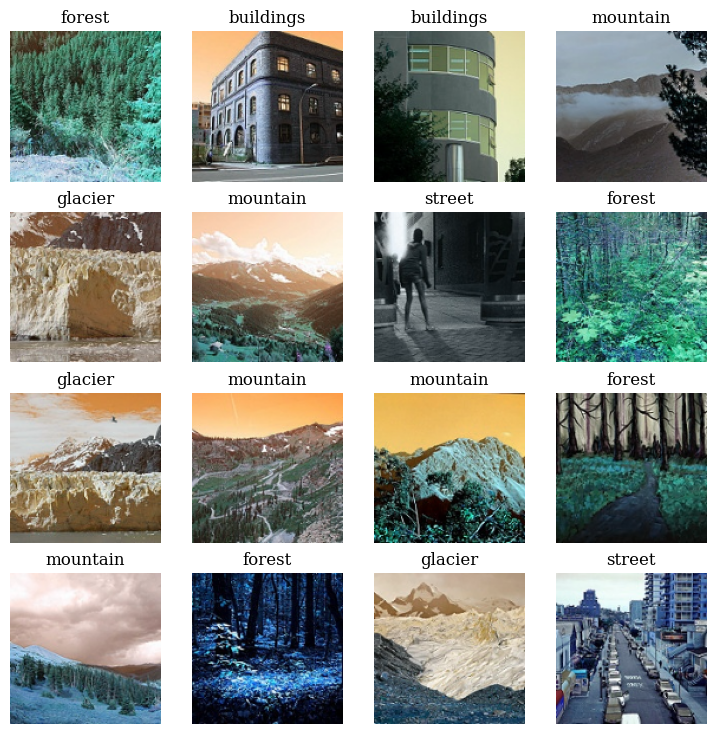

In [40]:
# Plot some random images from the testing data
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_id = random.randint(0, X_test.shape[0])
    X, y = X_test[random_id], y_test[random_id]
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.transpose(X, [1, 2, 0]))
    plt.title([key for key, value in code.items() if value == y][0])
    plt.axis(False)

In [41]:
# Convert the data into tensors
X_train, y_train = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train).type(torch.LongTensor)
X_test, y_test = torch.from_numpy(X_test).type(torch.float), torch.from_numpy(y_test).type(torch.LongTensor)
X_pred = torch.from_numpy(X_pred).type(torch.float)

In [42]:
# Apply normalization
X_train, X_test, X_pred = X_train/255, X_test/255, X_pred/255
X_train.shape, X_test.shape, X_pred.shape, y_train.shape, y_test.shape

(torch.Size([14034, 3, 128, 128]),
 torch.Size([3000, 3, 128, 128]),
 torch.Size([7301, 3, 128, 128]),
 torch.Size([14034]),
 torch.Size([3000]))

## **Build the Model (TinyVGG) using PyTorch**

In [43]:
# Setup the device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:
# Build the TinyVGG architecture
class TinyVGG(nn.Module):
    def __init__(self, in_channels=3, hidden_units=10, output_shape=10):
        super().__init__()
        # First conv layer
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Halves the spatial dimensions (128 -> 64)
        )
        
        # Second conv layer
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Halves the spatial dimensions again (64 -> 32)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 32 * 32, out_features=hidden_units)
        )
        
    def forward(self, X: torch.Tensor):
        X = self.conv_layer_1(X)
        X = self.conv_layer_2(X)
        X = self.classifier(X)
        return X

In [106]:
# Create an instance of TinyVGG
torch.manual_seed(42)

model = TinyVGG(in_channels=3, hidden_units=10, output_shape=len(code)).to(device)
model

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=10, bias=True)
  )
)

<center><img src="https://miro.medium.com/v2/resize:fit:1400/1*3ZkXJ-nIajuY3iX27w12aw.png" width="40%"></center>

In [110]:
# Setup the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

# Setup the accuracy function using torchmetrics
accuracy_fn = Accuracy(task="multiclass", num_classes=len(code)).to(device)

In [111]:
# Prepare dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)
pred_dataloader = DataLoader(TensorDataset(X_pred), batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of pred_dataloader: {len(pred_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 439 batches of 32
Length of test_dataloader: 94 batches of 32
Length of pred_dataloader: 229 batches of 32


In [112]:
# Start the training loop
torch.manual_seed(42)

# Define the epochs
epochs = 50

# Store all the history in a dictionary
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(epochs):
    print(f"Epoch: {epoch} | ", end="")
    
    ## Training
    train_avg_loss, train_avg_acc = 0.0, 0.0
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        # Set the model in training mode
        model.train()
        
        # Perform the steps
        y_pred = model(X)                # Forward pass
        loss = loss_fn(y_pred, y)        # Calculate the loss
        train_avg_loss += loss.item()    # Accumulate loss as a scalar
        
        # Calculate accuracy
        acc = accuracy_fn(y_pred.argmax(dim=1), y).item()
        train_avg_acc += acc
        
        optimizer.zero_grad()            # Zero the gradients
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Gradient descent
        
    # Divide total train_avg_loss and train_avg_acc by length of train dataloader
    train_avg_loss /= len(train_dataloader)
    train_avg_acc /= len(train_dataloader)
    
    ## Testing
    test_avg_loss, test_avg_acc = 0.0, 0.0
    model.eval()  # Set the model to evaluation mode
    
    with torch.inference_mode():  # Disable gradient computation for testing
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss = loss_fn(test_pred, y)
            test_avg_loss += test_loss.item()  # Accumulate test loss as a scalar
            
            # Calculate test accuracy
            test_acc = accuracy_fn(test_pred.argmax(dim=1), y).item()
            test_avg_acc += test_acc
        
    # Divide total test_avg_loss and test_avg_acc by length of test dataloader
    test_avg_loss /= len(test_dataloader)
    test_avg_acc /= len(test_dataloader)
    
    # Print out training and testing results
    history["epoch"].append(epoch)
    history["train_loss"].append(train_avg_loss)
    history["train_acc"].append(train_avg_acc)
    history["test_loss"].append(test_avg_loss)
    history["test_acc"].append(test_avg_acc)
    
    print(f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_avg_acc:.4f} | ", end="")
    print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_avg_acc:.4f}")

Epoch: 0 | Train Loss: 1.9164, Train Accuracy: 0.1894 | Test Loss: 1.7833, Test Accuracy: 0.1865
Epoch: 1 | Train Loss: 1.7313, Train Accuracy: 0.2844 | Test Loss: 1.6419, Test Accuracy: 0.3271
Epoch: 2 | Train Loss: 1.5692, Train Accuracy: 0.3768 | Test Loss: 1.5171, Test Accuracy: 0.4120
Epoch: 3 | Train Loss: 1.4139, Train Accuracy: 0.4738 | Test Loss: 1.3607, Test Accuracy: 0.4996
Epoch: 4 | Train Loss: 1.3124, Train Accuracy: 0.5067 | Test Loss: 1.3106, Test Accuracy: 0.5100
Epoch: 5 | Train Loss: 1.2842, Train Accuracy: 0.5175 | Test Loss: 1.2937, Test Accuracy: 0.5209
Epoch: 6 | Train Loss: 1.2719, Train Accuracy: 0.5233 | Test Loss: 1.3068, Test Accuracy: 0.5142
Epoch: 7 | Train Loss: 1.2634, Train Accuracy: 0.5240 | Test Loss: 1.2804, Test Accuracy: 0.5228
Epoch: 8 | Train Loss: 1.2552, Train Accuracy: 0.5294 | Test Loss: 1.2893, Test Accuracy: 0.5178
Epoch: 9 | Train Loss: 1.2481, Train Accuracy: 0.5292 | Test Loss: 1.2630, Test Accuracy: 0.5294
Epoch: 10 | Train Loss: 1.2409

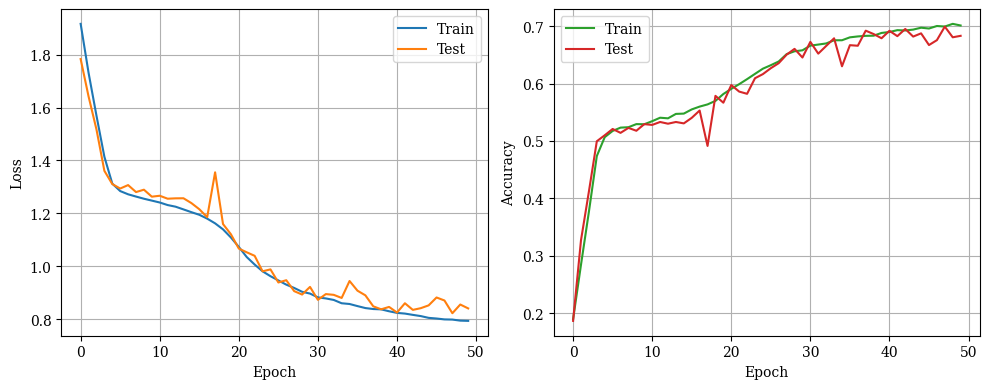

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes = axes.flatten()

sns.lineplot(x=history["epoch"], y=history["train_loss"], label="Train", ax=axes[0])
sns.lineplot(x=history["epoch"], y=history["test_loss"], label="Test", ax=axes[0])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid();

sns.lineplot(x=history["epoch"], y=history["train_acc"], c="C2", label="Train", ax=axes[1])
sns.lineplot(x=history["epoch"], y=history["test_acc"], c="C3", label="Test", ax=axes[1])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()

plt.tight_layout();